# Mesures de distance

Dans le notebook précédent, nous avons observé certaines variables très corrélées, ce qui a un impact sur l'interprétation de la distance euclidienne. En effet, deux observations peuvent avoir la même distance numérique, mais l'une se trouve à l'intérieur d'un nuage de points tandis que l'autre en est plutôt très éloignée. Notre opération de standardisation devrait amoindrir cet effet, mais on observe toujours une forte corrélation entre certaines variables. Dans ce notebook, nous évaluerons donc les différentes métriques de distance afin de déterminer laquelle utiliser pour nos classifieurs. Veuillez noter que, puisque nos données sont centrées et réduites, nous parlerons plutôt d'une matrice de corrélation plutôt qu'une matrice de covariacne. 

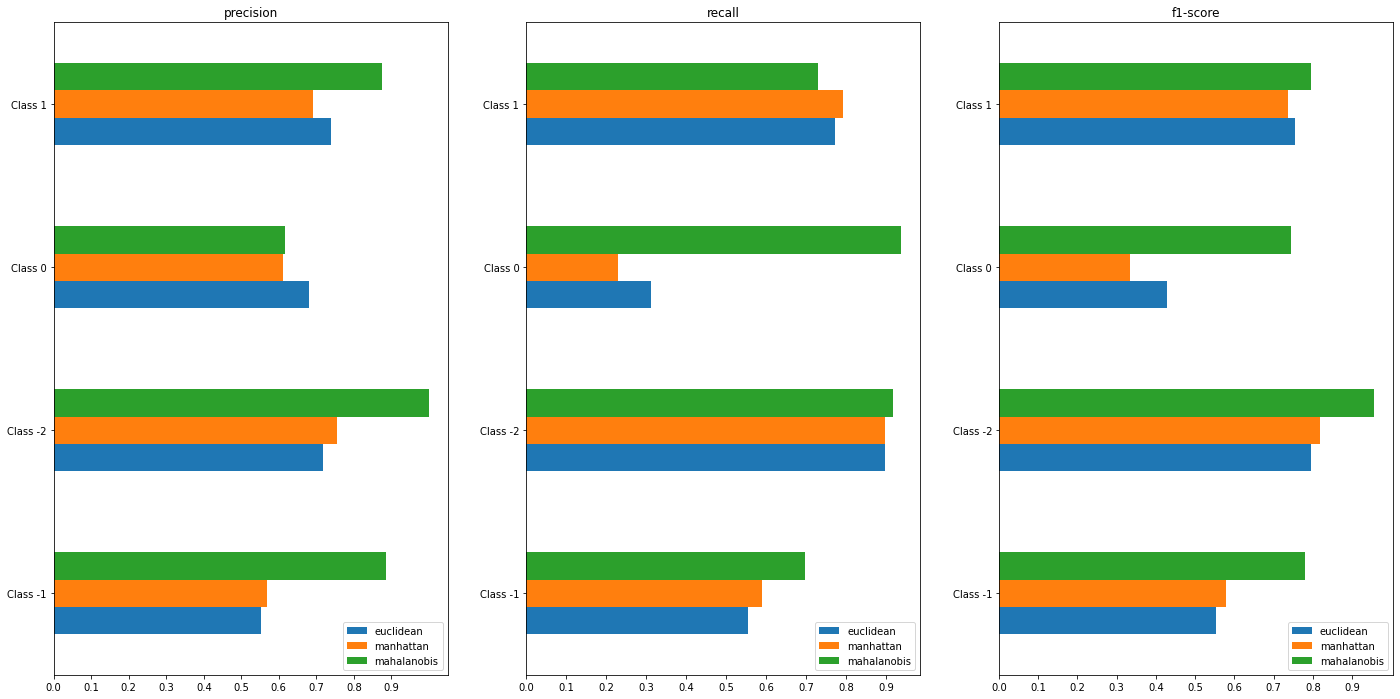

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from models import available_distances, KNN, NearestCentroid
from collections import defaultdict

# Chargement des données
df = pd.read_csv("./QSAR_10best_dataset.csv")
X, y = df.loc[:, df.columns != "Class"].to_numpy(), df.loc[:, "Class"].to_numpy()
n_classes = 5

# Encodage des classes pour faciliter leur traitement par les classifieurs
le = LabelEncoder()
le.fit(y)

# Distance de Mahalanobis
def mahalanobis(X: np.array, mu: np.array, S: np.array):
    S_inv = np.linalg.inv(S) + 1e-12
    return (X - mu).T @ S_inv @ (X - mu)

# Fonction utilitaire permet d'entraîner un classifieur du plus proche centroid
def nearest_centroid_classifier(data: np.array, targets, label_enc, dist_measure="euclidean"):
    clf = NearestCentroid(label_encoder=label_enc, metric=dist_measure)
    clf.fit(data, targets)
    y_pred = clf.predict(data)
    return clf.evaluate(targets, y_pred)

# On évalue le classifieur sur les différentes métriques disponibles
# (Manhattan, Mahalanobis, Euclidienne)
d = defaultdict()
for dist_measure in available_distances:
    d[dist_measure] = nearest_centroid_classifier(X, y, le, dist_measure)

# Affichage des résultats
f, axs = plt.subplots(1, 3, figsize=(24, 12))

dfs = defaultdict()
for eval_metric in ["precision", "recall", "f1-score"]:
    dfs[eval_metric] = pd.concat(
        [dframe.loc[eval_metric][0:4].rename(name) for name, dframe in d.items()], axis=1
    )
for ax, df_tuple in zip(axs, dfs.items()):
    name, dframe = df_tuple
    dframe.plot(kind="barh", ax=ax)
    ax.set_title(name)
    ax.set_xticks(np.arange(0, 1, step=0.1))

plt.show()

Le graphique précédent nous informe que la distance de Mahalanobis produit, de manière consistante, de meilleurs résultats en termes de Precision, Recall et F1-score. La supériorité de cette métrique est très marquée pour la classe 0.

Nous avons utilisé une matrice de corrélation différente pour chacune des classes dans le calcul de Mahalanobis. Tel que vu dans le dernier notebook, la corrélation entre chaque variables varie grandememnt en fonction des classes. Pour prendre en compte cette variation dans la distance de Mahalanobis, nous devons utiliser une matrice de corrélation pour chaque classe. Par contraste, l'utilisation d'une matrice de corrélation unique perd la spécificité de chacune des classe. 